## Comparing data storage

In [1]:
import numpy as np
import pandas as pd
import os, sys
from glob import glob
from h5py import File
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from fish_proc.utils.memory import get_process_memory, clear_variables
cameraNoiseMat = '/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'
dir_root = '/nrs/ahrens/Yu/SPIM/active_dataset/glia_neuron_imaging/20161109/fish2/20161109_2_1_6dpf_GFAP_GC_Huc_RG_GA_CL_fb_OL_f0_0GAIN_20161109_211950/raw'
import warnings
warnings.filterwarnings('ignore')
import dask.array as da
from utils import *
import zarr

## Set up dask

In [2]:
import fish_proc.utils.dask_ as fdask
cluster, client = fdask.setup_workers(10)
client

Client Scheduler: tcp://10.36.111.11:38834 Dashboard: http://10.36.111.11:38170/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load file to dask

In [3]:
files = sorted(glob(dir_root+'/*.h5'))
chunks = File(files[0],'r')['default'].shape
data = da.stack([da.from_array(File(fn,'r')['default'], chunks=chunks) for fn in files])

## Pixel denoise

In [4]:
from fish_proc.utils.getCameraInfo import getCameraInfo
cameraInfo = getCameraInfo(dir_root)
denoised_data = data.map_blocks(lambda v: pixelDenoiseImag(v, cameraInfo=cameraInfo), dtype='float32')

### Make sure the file size is reasonable

In [5]:
_ = File(files[0],'r')['default'].value
np.save('frame_one', _.astype('int16'))
save_h5('frame_one.h5', _, dtype='uint16')

In [6]:
print('Orginal file size --')
print(os.path.getsize(files[0])/1e6)
print('Orginal file size in numpy array --')
print(os.path.getsize('frame_one.npy')/1e6)
print('Orginal file size in h5 with compression --')
print(os.path.getsize('frame_one.h5')/1e6)

Orginal file size --
62.001838
Orginal file size in numpy array --
201.32672
Orginal file size in h5 with compression --
62.001838


In [7]:
max_value = data.max().compute()
print(f'max value in the raw image is {max_value}')

max value in the raw image is 8160


In [8]:
med_win = len(denoised_data)
ref_img = denoised_data[med_win-100:med_win+100].mean(axis=0).compute()
np.save('motion_fix_', ref_img) # size of reference image should be minimized

In [20]:
save_h5_rescale('motion_fix_.h5', ref_img, reset_max_int=max_value)
save_h5_rescale('motion_fix_full_.h5', ref_img)
save_h5('motion_fix_float_16_.h5', ref_img, dtype='float16')

In [12]:
cluster.stop_all_jobs()
# cluster.close()

In [21]:
print('Reference image file size in numpy --')
print(os.path.getsize('motion_fix_.npy')/1e6)
print('Reference image file size in h5 with compression and rescale --')
print(os.path.getsize('motion_fix_.h5')/1e6)
print('Reference image file size in h5 with compression and rescale with full range --')
print(os.path.getsize('motion_fix_full_.h5')/1e6)
print('Reference image file size in h5 with compression --')
print(os.path.getsize('motion_fix_float_16_.h5')/1e6)

Reference image file size in numpy --
402.653312
Reference image file size in h5 with compression and rescale --
84.160991
Reference image file size in h5 with compression and rescale with full range --
116.571913
Reference image file size in h5 with compression --
127.307321


In [13]:
reg_img_ = File('motion_fix_full_.h5', 'r')

In [16]:
reg_img_['scale'].value

array([1.0000000e-06, 1.3484015e+02], dtype=float32)

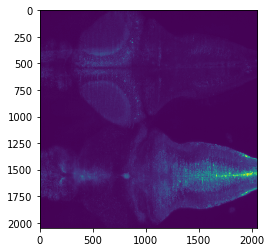

In [17]:
reg_img_max = reg_img_['default'].value.max(axis=0)
plt.imshow(reg_img_max)
plt.show()

In [19]:
reg_img_.close()